## Now that we have data, let's make it look "pretty" #RIPBurtReynolds

In [1]:
from bs4 import BeautifulSoup

import nltk
import pandas as pd
import requests
from time import time

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np


from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

from sklearn import metrics

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
lakers = pd.read_csv('lakers scrape 2018-09-07 15:00:39.csv')
cavs = pd.read_csv('cavs scrape 2018-09-07 15:00:39.csv')

In [3]:
lakers.head()

,index,approved_at_utc,approved_by,archived,author,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,...,thumbnail_height,thumbnail_width,title,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,0,NaN,NaN,False,AutoModerator,NaN,NaN,NaN,[],NaN,...,NaN,NaN,Weekly Lakers Ticket Sales (September 01 - Sep...,16,https://www.reddit.com/r/lakers/comments/9c485...,[],NaN,False,all_ads,6
1,1,NaN,NaN,False,AutoModerator,NaN,NaN,NaN,[],NaN,...,NaN,NaN,Daily Off Season Lakers Discussion Thread - Se...,5,https://www.reddit.com/r/lakers/comments/9dupc...,[],NaN,False,all_ads,6
2,2,NaN,NaN,False,Luvsicpt2,NaN,NaN,black,[],b2acfc2e-6a1a-11e5-8246-0e49db09c135,...,140.0,140.0,Playing 2k19 when...,116,https://i.imgur.com/VCe3veY.jpg,[],NaN,False,all_ads,6
3,3,NaN,NaN,False,sevens777,NaN,NaN,NaN,[],NaN,...,140.0,140.0,The King loves staring at his enemies. Even in...,332,https://i.redd.it/s0z8yp6k2sk11.jpg,[],NaN,False,all_ads,6
4,4,NaN,NaN,False,sevens777,NaN,NaN,NaN,[],NaN,...,140.0,140.0,LeBron out there being the King of NY,138,https://i.redd.it/llb3v0512sk11.jpg,[],NaN,False,all_ads,6


In [4]:
cavs.head()

,index,approved_at_utc,approved_by,archived,author,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,...,thumbnail_height,thumbnail_width,title,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,0,NaN,NaN,False,AutoModerator,NaN,NaN,NaN,[],NaN,...,NaN,NaN,Weekly General Discussion Thread -- September ...,8,https://www.reddit.com/r/clevelandcavs/comment...,[],NaN,False,all_ads,6
1,1,NaN,NaN,False,AutoModerator,NaN,NaN,NaN,[],NaN,...,NaN,NaN,"Free Talk Friday -- September 07, 2018",5,https://www.reddit.com/r/clevelandcavs/comment...,[],NaN,False,all_ads,6
2,2,NaN,NaN,False,Parabolaz,NaN,NaN,NaN,[],NaN,...,140.0,140.0,"Just the goat, and some laker.",363,https://i.redd.it/ixkn9v1f1rk11.jpg,[],NaN,False,all_ads,6
3,3,NaN,NaN,False,dreamteamreddit,NaN,NaN,NaN,[],NaN,...,140.0,140.0,Kyrie Irving surprises a Cavaliers fan,33,https://i.imgur.com/WhiBySr.gifv,[],NaN,False,all_ads,6
4,4,NaN,NaN,False,Alex_Swervitz,NaN,NaN,CHAMPS,[],NaN,...,140.0,140.0,New banner downtown.,13,https://i.redd.it/fnd9tj5wjtk11.jpg,[],NaN,False,all_ads,6


In [5]:
features = ['author', 'num_comments', 'score', 'title']

lakers = lakers[features]
lakers['subreddit'] = 0

cavs = cavs[features]
cavs['subreddit'] = 1

In [6]:
frames = [lakers, cavs]

posts = pd.concat(frames)

posts.head(3)

,author,num_comments,score,title,subreddit
0,AutoModerator,11,16,Weekly Lakers Ticket Sales (September 01 - Sep...,0
1,AutoModerator,7,5,Daily Off Season Lakers Discussion Thread - Se...,0
2,Luvsicpt2,26,116,Playing 2k19 when...,0


In [7]:
X = posts['title']
y = posts['subreddit']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [9]:
y_train.value_counts(normalize=True)

0    0.519558
1    0.480442
Name: subreddit, dtype: float64

In [10]:
pipe = Pipeline([
    ('cv', CountVectorizer()), #stop_words=None
    ('mnb', MultinomialNB())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9736394557823129, 0.8549618320610687)

## Are You The Same Animal, But A Different Beast

In [11]:
cv = CountVectorizer(stop_words='english')

cv.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [12]:
X_train_cv = cv.transform(X_train)

In [13]:
X_test_cv = cv.transform(X_test)

In [14]:
eda = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())

In [15]:
eda['subreddit'] = y_train.values

In [16]:
eda.head()

,000,01,02,03,04,05,06,07,08,088,...,youtube,youtubers,yr,zero,zizic,zo,zu,zydrunas,ಠ_ಠ,ᴴᴰ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
eda.sum().sort_values(ascending=False)[:15]

subreddit    565
lebron       200
lakers       172
cavs          99
2018          91
kobe          84
season        75
cavaliers     71
cleveland     70
james         65
game          63
nba           62
new           52
league        51
love          44
dtype: int64

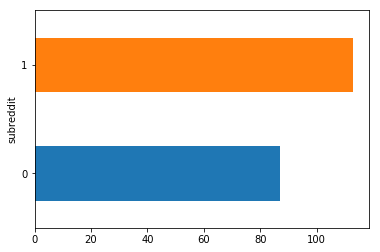

In [18]:
eda.groupby('subreddit').sum()['lebron'].plot(kind='barh');

In [19]:
eda.groupby('subreddit').sum()['lebron']

subreddit
0     87
1    113
Name: lebron, dtype: int64

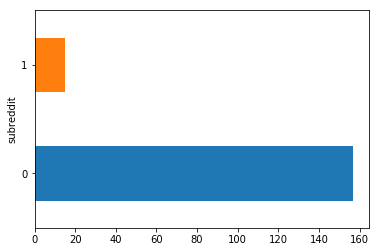

In [20]:
eda.groupby('subreddit').sum()['lakers'].plot(kind='barh');

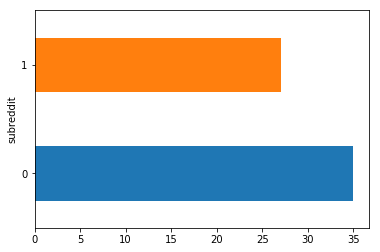

In [21]:
eda.groupby('subreddit').sum()['nba'].plot(kind='barh')

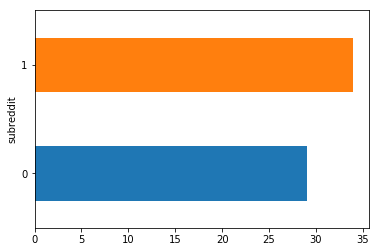

In [22]:
eda.groupby('subreddit').sum()['game'].plot(kind='barh')

In [23]:
eda.groupby('subreddit').sum()['game']

subreddit
0    29
1    34
Name: game, dtype: int64

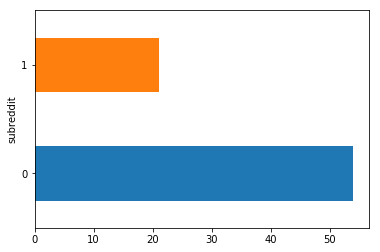

In [24]:
eda.groupby('subreddit').sum()['season'].plot(kind='barh')

In [25]:
eda.groupby('subreddit').sum()['season']

subreddit
0    54
1    21
Name: season, dtype: int64

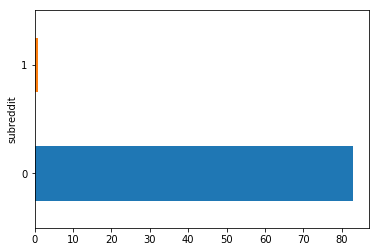

In [26]:
eda.groupby('subreddit').sum()['kobe'].plot(kind='barh')

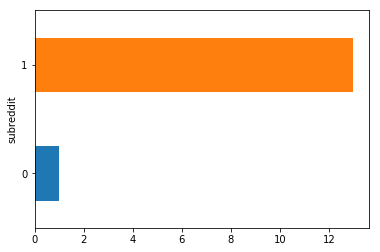

In [27]:
eda.groupby('subreddit').sum()['kyrie'].plot(kind='barh')

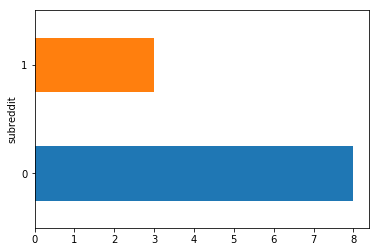

In [28]:
eda.groupby('subreddit').sum()['magic'].plot(kind='barh')

In [29]:
eda.groupby('subreddit').sum()['magic']

subreddit
0    8
1    3
Name: magic, dtype: int64

In [30]:
lcv = LogisticRegressionCV()
mnb = MultinomialNB()
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
etc = ExtraTreesClassifier()
rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()

list_of_classifiers = [lcv, mnb, knc, dtc, etc, rfc, abc, gbc]

In [31]:
for each in list_of_classifiers:
    print(str(each).split('(')[0])
    each.fit(X_train_cv, y_train)
    print('Training score:')
    print(each.score(X_train_cv, y_train))
    print('Testing score:')
    print(each.score(X_test_cv, y_test))
    print()

LogisticRegressionCV
Training score:
0.9957482993197279
Testing score:
0.8346055979643766

MultinomialNB
Training score:
0.9710884353741497
Testing score:
0.8753180661577609

KNeighborsClassifier
Training score:
0.8877551020408163
Testing score:
0.7786259541984732

DecisionTreeClassifier
Training score:
0.9974489795918368
Testing score:
0.7837150127226463

ExtraTreesClassifier
Training score:
0.9974489795918368
Testing score:
0.8142493638676844

RandomForestClassifier
Training score:
0.9914965986394558
Testing score:
0.8269720101781171

AdaBoostClassifier
Training score:
0.8741496598639455
Testing score:
0.7811704834605598

GradientBoostingClassifier
Training score:
0.891156462585034
Testing score:
0.7913486005089059



## Lord VADER Rules Over ALL!!!!

In [32]:
corpus = list(posts['title'])

corpus[0]

'Weekly Lakers Ticket Sales (September 01 - September 07)'

In [33]:
sia = SentimentIntensityAnalyzer()

sia.polarity_scores(corpus[0])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [34]:
dicts = []

for post in corpus:
    scores = sia.polarity_scores(post)
    scores['title'] = post
    dicts.append(scores)
    
vader = pd.DataFrame(dicts)
vader.head()

,compound,neg,neu,pos,title
0,0.0000,0.000,1.000,0.000,Weekly Lakers Ticket Sales (September 01 - Sep...
1,0.0000,0.000,1.000,0.000,Daily Off Season Lakers Discussion Thread - Se...
2,0.2023,0.000,0.526,0.474,Playing 2k19 when...
3,0.1280,0.201,0.566,0.233,The King loves staring at his enemies. Even in...
4,0.0000,0.000,1.000,0.000,LeBron out there being the King of NY


In [35]:
vader['subreddit'] = posts['subreddit'].values

In [36]:
vader.groupby('subreddit').mean()

,compound,neg,neu,pos
subreddit,,,,
0,0.157276,0.031415,0.851179,0.114958
1,0.155412,0.032899,0.850472,0.115300


In [37]:
vader.sort_values(by='pos', ascending=False).head(5)

,compound,neg,neu,pos,title,subreddit
181,0.6124,0.0,0.167,0.833,Throwbacks? Yes Please,0
476,0.6249,0.0,0.196,0.804,Great throwback,0
276,0.7650,0.0,0.233,0.767,Best Value in NBA?,0
1124,0.5080,0.0,0.233,0.767,YES BABY!!,1
168,0.4404,0.0,0.256,0.744,Championship Contenders?,0


In [38]:
vader.sort_values(by='neg', ascending=False).head(5)

,compound,neg,neu,pos,title,subreddit
585,-0.6523,0.684,0.316,0.0,Lance is NASTY,0
491,-0.6219,0.671,0.329,0.0,LeBron vs. Haters!!!,0
787,-0.2263,0.655,0.345,0.0,Forgotten Laksers,0
76,-0.4404,0.592,0.408,0.0,Lakers.com frustrates me,0
439,-0.5267,0.524,0.476,0.0,Ignorant foreigner confused by ticket sales,0


In [39]:
vader.sort_values(by='neu', ascending=False).head(5)

,compound,neg,neu,pos,title,subreddit
0,0.0,0.0,1.0,0.0,Weekly Lakers Ticket Sales (September 01 - Sep...,0
885,0.0,0.0,1.0,0.0,Photo from today of Cedi Osman working out wit...,1
817,0.0,0.0,1.0,0.0,"Just the goat, and some laker.",1
819,0.0,0.0,1.0,0.0,New banner downtown.,1
820,0.0,0.0,1.0,0.0,Just seen on the new NBA 2k. Literally Unplaya...,1


## Multinomial Naive Bayes looks like the best option.  What can we do to make the fit better

In [40]:
pipe = Pipeline([
      ('cv', CountVectorizer(stop_words='english', ngram_range=(1,2))),
      ('mnb', MultinomialNB())
    ])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9923469387755102, 0.8778625954198473)

In [41]:
pipe = Pipeline([
      ('cv', CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=2)),
      ('mnb', MultinomialNB())
    ])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9464285714285714, 0.8727735368956743)

In [42]:
pipe = Pipeline([
      ('cv', CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=2)),
      ('mnb', MultinomialNB(alpha=2))
    ])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9362244897959183, 0.8676844783715013)

In [43]:
predicted = pipe.predict(X_test)
 
def printreport(exp, pred):
    print(pd.crosstab(exp, pred, rownames=['Actual'], colnames=['Predicted']))
 
    print('\n \n')
    print(classification_report(exp, pred))
 
printreport(y_test, predicted)

Predicted    0    1
Actual             
0          185   19
1           33  156

 

             precision    recall  f1-score   support

          0       0.85      0.91      0.88       204
          1       0.89      0.83      0.86       189

avg / total       0.87      0.87      0.87       393



In [44]:
metrics.accuracy_score(y_test, predicted)

0.8676844783715013